in this part, first models will be built and compared on the the z_scaled dataset, which has been cleaned, applied feature selection, and standardized, containing 32 features (excluding fraud label).

then, the best model will be built on the dataset that has been reduced to 5  component (the best and least to explain 95% variance) by pca. The results on two dataset will be compared.

at last, the best model will be applied on the best dataset's out of time (oot) set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

# Model imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model selection and evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, roc_curve, precision_recall_curve, 
                           confusion_matrix, classification_report, average_precision_score)
# self-definced functions
from func import optimize_dtypes

# Load dataset

In [2]:
z_scaled = pd.read_csv('./data/z_scaled.csv', index_col=0)
print('dataset shape: ', z_scaled.shape)
print('5 sample:')
display(z_scaled.sample(5))
z_scaled = optimize_dtypes(z_scaled)

dataset shape:  (981694, 39)
5 sample:


,fulladdress_count_30,address_count_14,fulladdress_count_14,address_count_7,fulladdress_count_7,fulladdress_count_0_by_7,address_count_1,fulladdress_count_1,ssn_dob_count_30,ssn_count_30,...,fulladdress_homephone_count_7,fulladdress_homephone_count_0_by_30,ssn_dob_count_0_by_14,ssn_ssn_count_0_by_30,ssn_firstname_count_0_by_14,ssn_ssn_count_7,ssn_lastname_count_0_by_30,ssn_name_count_0_by_30,name_dob_count_0_by_30,fraud_label
780119,-0.10148,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.09749,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.1727,0.177126,0
196355,-0.10148,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.09749,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.1727,0.177126,0
966557,-0.10148,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.09749,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.1727,0.177126,0
971683,-0.10148,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.09749,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.1727,0.177126,0
47035,-0.10148,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.09749,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.1727,0.177126,0



OPTIMIZING DATA TYPES
----------------------------------------
Starting memory usage: 299.59 MB
Ending memory usage: 150.73 MB
Memory reduction: 49.7%


## split statistics
- 80% train, test set (X, y will be divided by train_test_split function) and
- 20% Out Of Time (OOT) set for validation of the best model

In [3]:
total = z_scaled.shape[0]
X = z_scaled.drop(['fraud_label'], axis=1)
y = z_scaled.fraud_label
X_oot = X[round(total*0.8):]
y_oot = y[round(total*0.8):]
X = X[0:round(total*0.8)]
y = y[0:round(total*0.8)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(f"Train set loaded: {X_train.shape}")
print(f"Test set loaded: {X_test.shape}")
print(f"OOT set loaded: {X_oot.shape}")
print("check length sum euqals to original length: ",len(y_train)+len(y_test)+len(y_oot)==len(z_scaled.fraud_label))
print(f"Fraud rate in train: {y_train.mean()*100:.2f}%")

Train set loaded: (549748, 38)
Test set loaded: (235607, 38)
OOT set loaded: (196339, 38)
check length sum euqals to original length:  True
Fraud rate in train: 1.45%


In [4]:
del z_scaled

# Build and Compare Baseline Models

traditional svm works really slow for this huge dataset, and from the previous research, it didn't show any better than GBDT, so just skip it here. 
- have not tried replacing it with its approximations, such as LinearSVC and SGDClassifier

In [4]:
baseline_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    #'SVM': SVC(probability=True, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbosity=-1)
}


baseline_results = {}

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    baseline_results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'avg_precision': average_precision_score(y_test, y_pred_proba),
        'train_time': time.time() - start_time
    }
    
    print(f"ROC-AUC: {baseline_results[name]['roc_auc']:.4f}")
    print(f"F1 Score: {baseline_results[name]['f1']:.4f}")
    print(f"Training time: {baseline_results[name]['train_time']:.2f} seconds")

# Display baseline results
baseline_df = pd.DataFrame(baseline_results).T
print("\nBaseline Model Comparison:")
print(baseline_df.round(4))


Training Logistic Regression...
ROC-AUC: 0.7696
F1 Score: 0.5582
Training time: 1.42 seconds

Training Decision Tree...
ROC-AUC: 0.7250
F1 Score: 0.5852
Training time: 1.09 seconds

Training Random Forest...
ROC-AUC: 0.7643
F1 Score: 0.5937
Training time: 4.76 seconds

Training Gradient Boosting...
ROC-AUC: 0.7647
F1 Score: 0.6145
Training time: 17.59 seconds

Training Neural Network...
ROC-AUC: 0.7686
F1 Score: 0.6159
Training time: 32.89 seconds

Training XGBoost...
ROC-AUC: 0.7673
F1 Score: 0.6051
Training time: 1.26 seconds

Training LightGBM...
ROC-AUC: 0.7667
F1 Score: 0.6119
Training time: 1.95 seconds

Baseline Model Comparison:
                                                                 model  \
Logistic Regression  LogisticRegression(max_iter=1000, random_state...   
Decision Tree                  DecisionTreeClassifier(random_state=42)   
Random Forest        (DecisionTreeClassifier(max_features='sqrt', r...   
Gradient Boosting    ([DecisionTreeRegressor(criterion='fr

In [29]:
baseline_df.to_csv('Baseline Model Performance.csv')

For Fraud Detection, Recall (aka True Positive Rate or Sensitivity) is crucial that we want to catch as many fraud cases as possible, i.e.the cost of missing a true positive is high. However, it can also increase the risk of false alarms. Thus, to choose the proper models for further training, we have to consider all metrics and prioritize certain metrics over others. After a glance of the above results, GBDT and NN are the two choices for me, just like what we have done in the paper years ago. For future efficiency, let's utilize self-defined function combining multiple metrics with customizable weights.
* and training time may need to be taken into consideration in real situation
$$Recall = \frac{TP}{TP + FN}$$

In [2]:
baseline_df = pd.read_csv('Baseline Model Performance.csv', index_col=0)
#baseline_df

In [6]:
from func import select_best_fraud_models
fraud_weights = {
        'recall': 0.35,       # Most important - catch fraud cases
        'f1': 0.25,           # Balance of precision and recall
        'precision': 0.15,    # Avoid too many false alarms
        'roc_auc': 0.15,      # Overall discrimination ability
        'avg_precision': 0.10 # Performance across thresholds
    }
top_models, weighted_score = select_best_fraud_models(baseline_df, top_n=3, weights=fraud_weights)

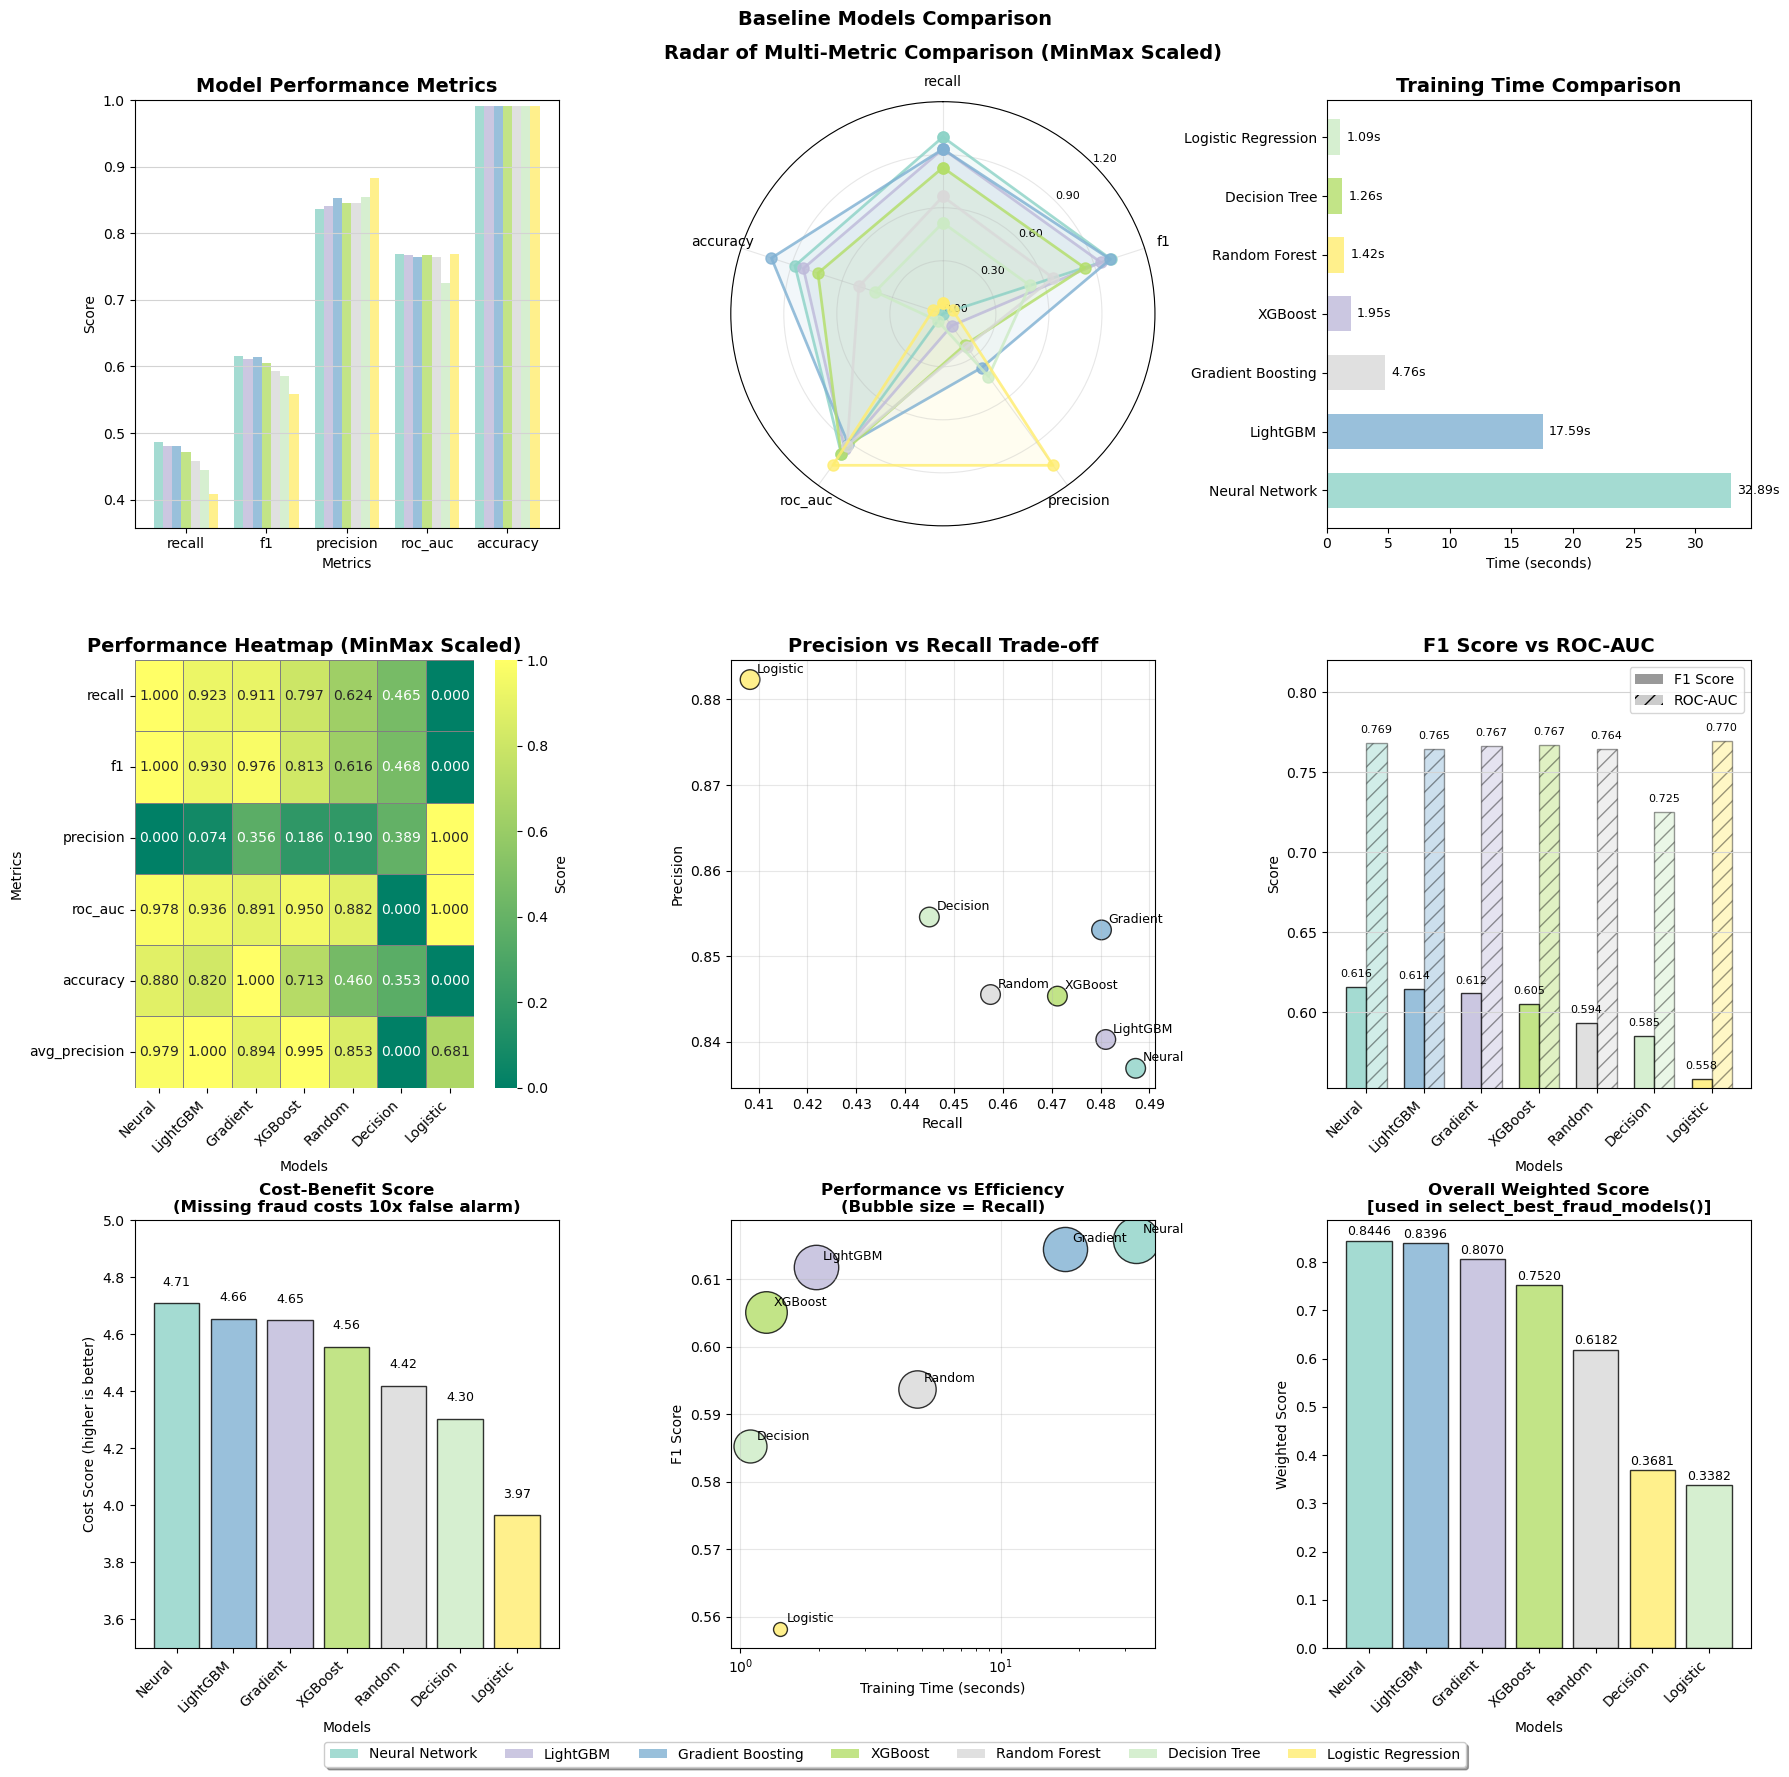

In [5]:
from func import plot_model_comparison
plot_model_comparison(baseline_df, weights = fraud_weights, top_n=3, 
                      figsize=(18, 18), figsave=True, figtitle = 'Baseline Models Comparison')

# Hyperparameter Optimization
Select top 3 models for optimization based on baseline performance

In [7]:
top_models

['Neural Network', 'Gradient Boosting', 'LightGBM']

>**a little plug here**, to train faster, if there is cuda GPUS (usually windows OS), can use:
>- XGBClassifier(tree_method='gpu_hist', ...)
>- LGBMClassifier(device='gpu', ...)
>- NN: switch to PyTorch or TensorFlow 
>- SVM: RAPIDS cuML or ThunderSVM  
>from the above, for mac silicon, except NN (tf is recommended than pytorch), others are not supported

In [8]:
from optimization_func import optimize_all_models_parallel
optimized_models = optimize_all_models_parallel(X_train, y_train, 
                                                method='optuna', n_trials=50, 
                                                models=top_models,
                                                verbose='medium')

Starting parallel optimization...

Starting Optuna optimization for Neural Network...

Starting Optuna optimization for Gradient Boosting...

Starting Optuna optimization for LightGBM...
Gradient Boosting: 100%|████████████████████| 50/50 [1065s<00:00, 21.30s/it] Best Trial: 27, Best F1: 0.6161

Completed Gradient Boosting Optuna optimization in 1064.99 seconds
Best F1 Score: 0.6161
Best Parameters: {'n_estimators': 549, 'max_depth': 3, 'learning_rate': 0.13759853943681635, 'subsample': 0.9654568616039398, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 0.8996880122162721, 'validation_fraction': 0.1221853105231159, 'n_iter_no_change': 5}

LightGBM: 100%|████████████████████| 50/50 [2263s<00:00, 45.27s/it] Best Trial: 32, Best F1: 0.6273 17660

Completed LightGBM Optuna optimization in 2263.49 seconds
Best F1 Score: 0.6273
Best Parameters: {'n_estimators': 534, 'max_depth': 4, 'learning_rate': 0.047678416454308495, 'num_leaves': 170, 'feature_fraction': 0.828894500064379

In [9]:
optimized_models

{'Neural Network': {'model': MLPClassifier(activation='tanh', alpha=2.4257829483624618e-05, batch_size=256,
                beta_1=0.9885083438243408, beta_2=0.9084256873681998,
                hidden_layer_sizes=(335, 91, 66),
                learning_rate_init=0.0005808383357321612, max_iter=283,
                n_iter_no_change=15, tol=0.0007982901696141564),
  'best_params': {'n_layers': 3,
   'layer1_size': 335,
   'layer2_size': 91,
   'layer3_size': 66,
   'alpha': 2.4257829483624618e-05,
   'learning_rate_init': 0.0005808383357321612,
   'beta_1': 0.9885083438243408,
   'beta_2': 0.9084256873681998,
   'activation': 'tanh',
   'batch_size': 256,
   'max_iter': 283,
   'n_iter_no_change': 15,
   'tol': 0.0007982901696141564},
  'best_score': 0.6212957073506776,
  'time_taken': 108.96663928031921,
  'study': <optuna.study.study.Study at 0x1774aa550>},
 'Gradient Boosting': {'model': GradientBoostingClassifier(learning_rate=0.13933550412179466, max_depth=5,
                       

In [10]:
pd.DataFrame(optimized_models).to_csv('Top3 Optimized Results.csv')

## Calculate the Optimized Models' Performance with the best parameters

load dataset again if the previous has been deleted

in the result dataset, the models are stored as string in the model row, need to convert them to real model objects to be trained

In [12]:
# optimized_models = pd.read_csv('Top3 Optimized Results.csv', index_col=0)
# optimized_models
# Convert string to actual model objects
# optimized_models = {name: eval(model_str) for name, model_str in dict(optimized_models.loc['model',:]).items()}

In [22]:
optimized_results = {}

for name, model in optimized_models.items():
    model = model['model']
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train model
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    optimized_results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'avg_precision': average_precision_score(y_test, y_pred_proba),
        'train_time': time.time() - start_time
    }
    
    print(f"ROC-AUC: {optimized_results[name]['roc_auc']:.4f}")
    print(f"F1 Score: {optimized_results[name]['f1']:.4f}")
    print(f"Training time: {optimized_results[name]['train_time']:.2f} seconds")

# Display optimized models results
optimized_df = pd.DataFrame(optimized_results).T
print("\nOptimized Model Comparison:")
print(optimized_df.round(4))


Training Neural Network...
ROC-AUC: 0.7678
F1 Score: 0.6236
Training time: 194.06 seconds

Training Gradient Boosting...
ROC-AUC: 0.7661
F1 Score: 0.6245
Training time: 10.48 seconds

Training LightGBM...
[LightGBM] [Warning] feature_fraction is set=0.8288945000643793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8288945000643793
[LightGBM] [Warning] bagging_fraction is set=0.6491411484297266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6491411484297266
[LightGBM] [Warning] feature_fraction is set=0.8288945000643793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8288945000643793
[LightGBM] [Warning] bagging_fraction is set=0.6491411484297266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6491411484297266
[LightGBM] [Info] Number of positive: 7989, number of negative: 541759
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 549748, number of used feature

In [23]:
optimized_df.to_csv('Optimized Model Performance.csv')

In [3]:
optimized_df = pd.read_csv('Optimized Model Performance.csv', index_col=0)
#optimized_df

check how much they have been optimized from their corresponding baseline models, to make sure the optimization is meaningful

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

# Model imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model selection and evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, roc_curve, precision_recall_curve, 
                           confusion_matrix, classification_report, average_precision_score)
# self-definced functions
from func import optimize_dtypes

In [2]:
fraud_weights = {
        'recall': 0.35,       # Most important - catch fraud cases
        'f1': 0.25,           # Balance of precision and recall
        'precision': 0.15,    # Avoid too many false alarms
        'roc_auc': 0.15,      # Overall discrimination ability
        'avg_precision': 0.10 # Performance across thresholds
    }

Figure saved to: ./Optimization Effect.png


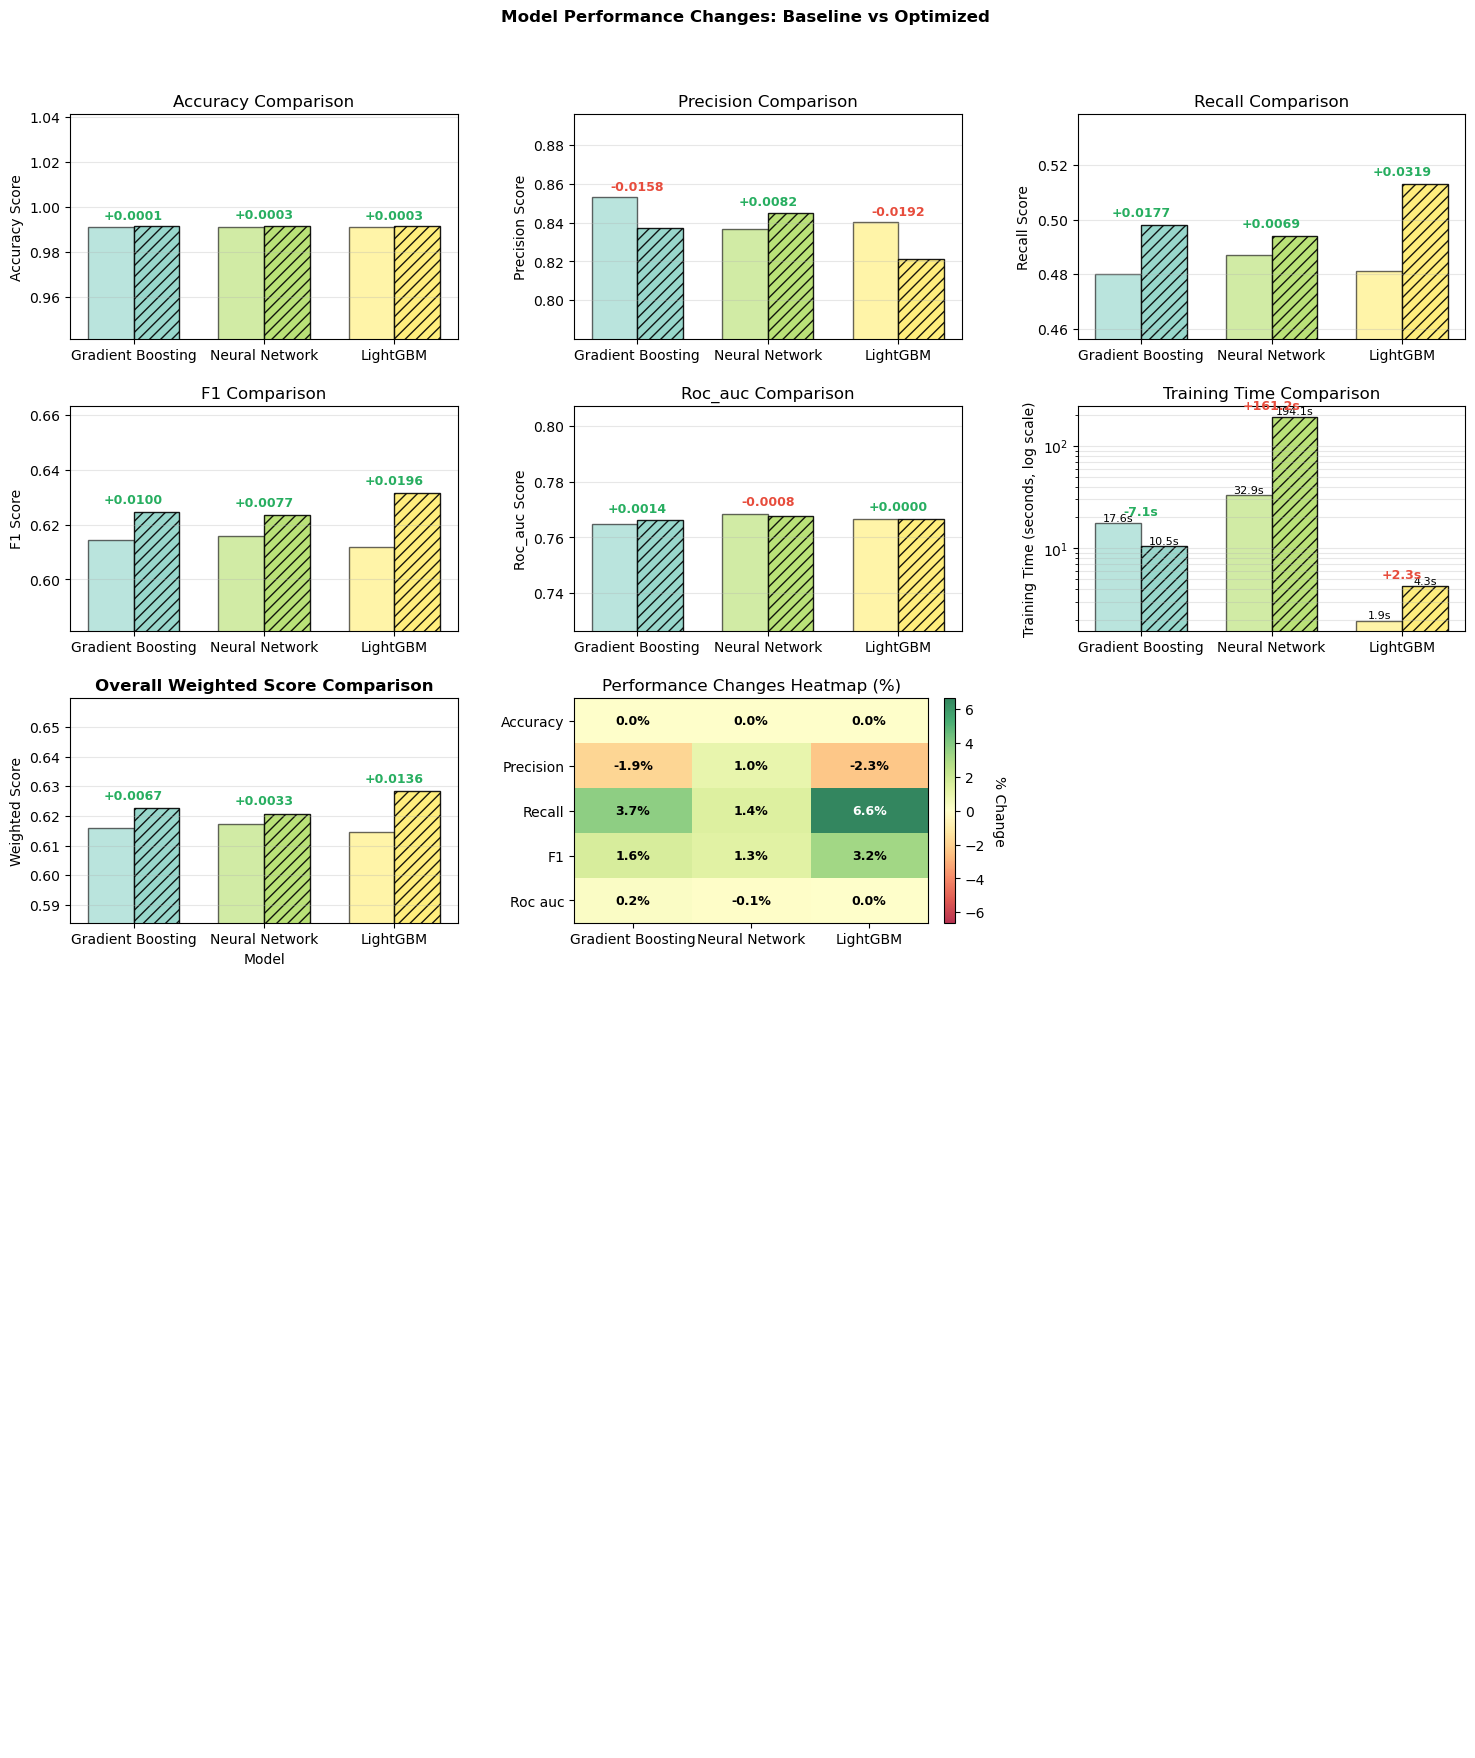

In [3]:
from func import compare_model
baseline_df = pd.read_csv('Baseline Model Performance.csv', index_col=0)
optimized_df = pd.read_csv('Optimized Model Performance.csv', index_col=0)
compare_model(baseline_df, optimized_df, 
              weights = fraud_weights,
              save_path = './Optimization Effect.png'
            )

again, auto-select the best model, only one for this time

In [4]:
from func import select_best_fraud_models
top_models, weighted_score = select_best_fraud_models(optimized_df, top_n=1, weights=fraud_weights)

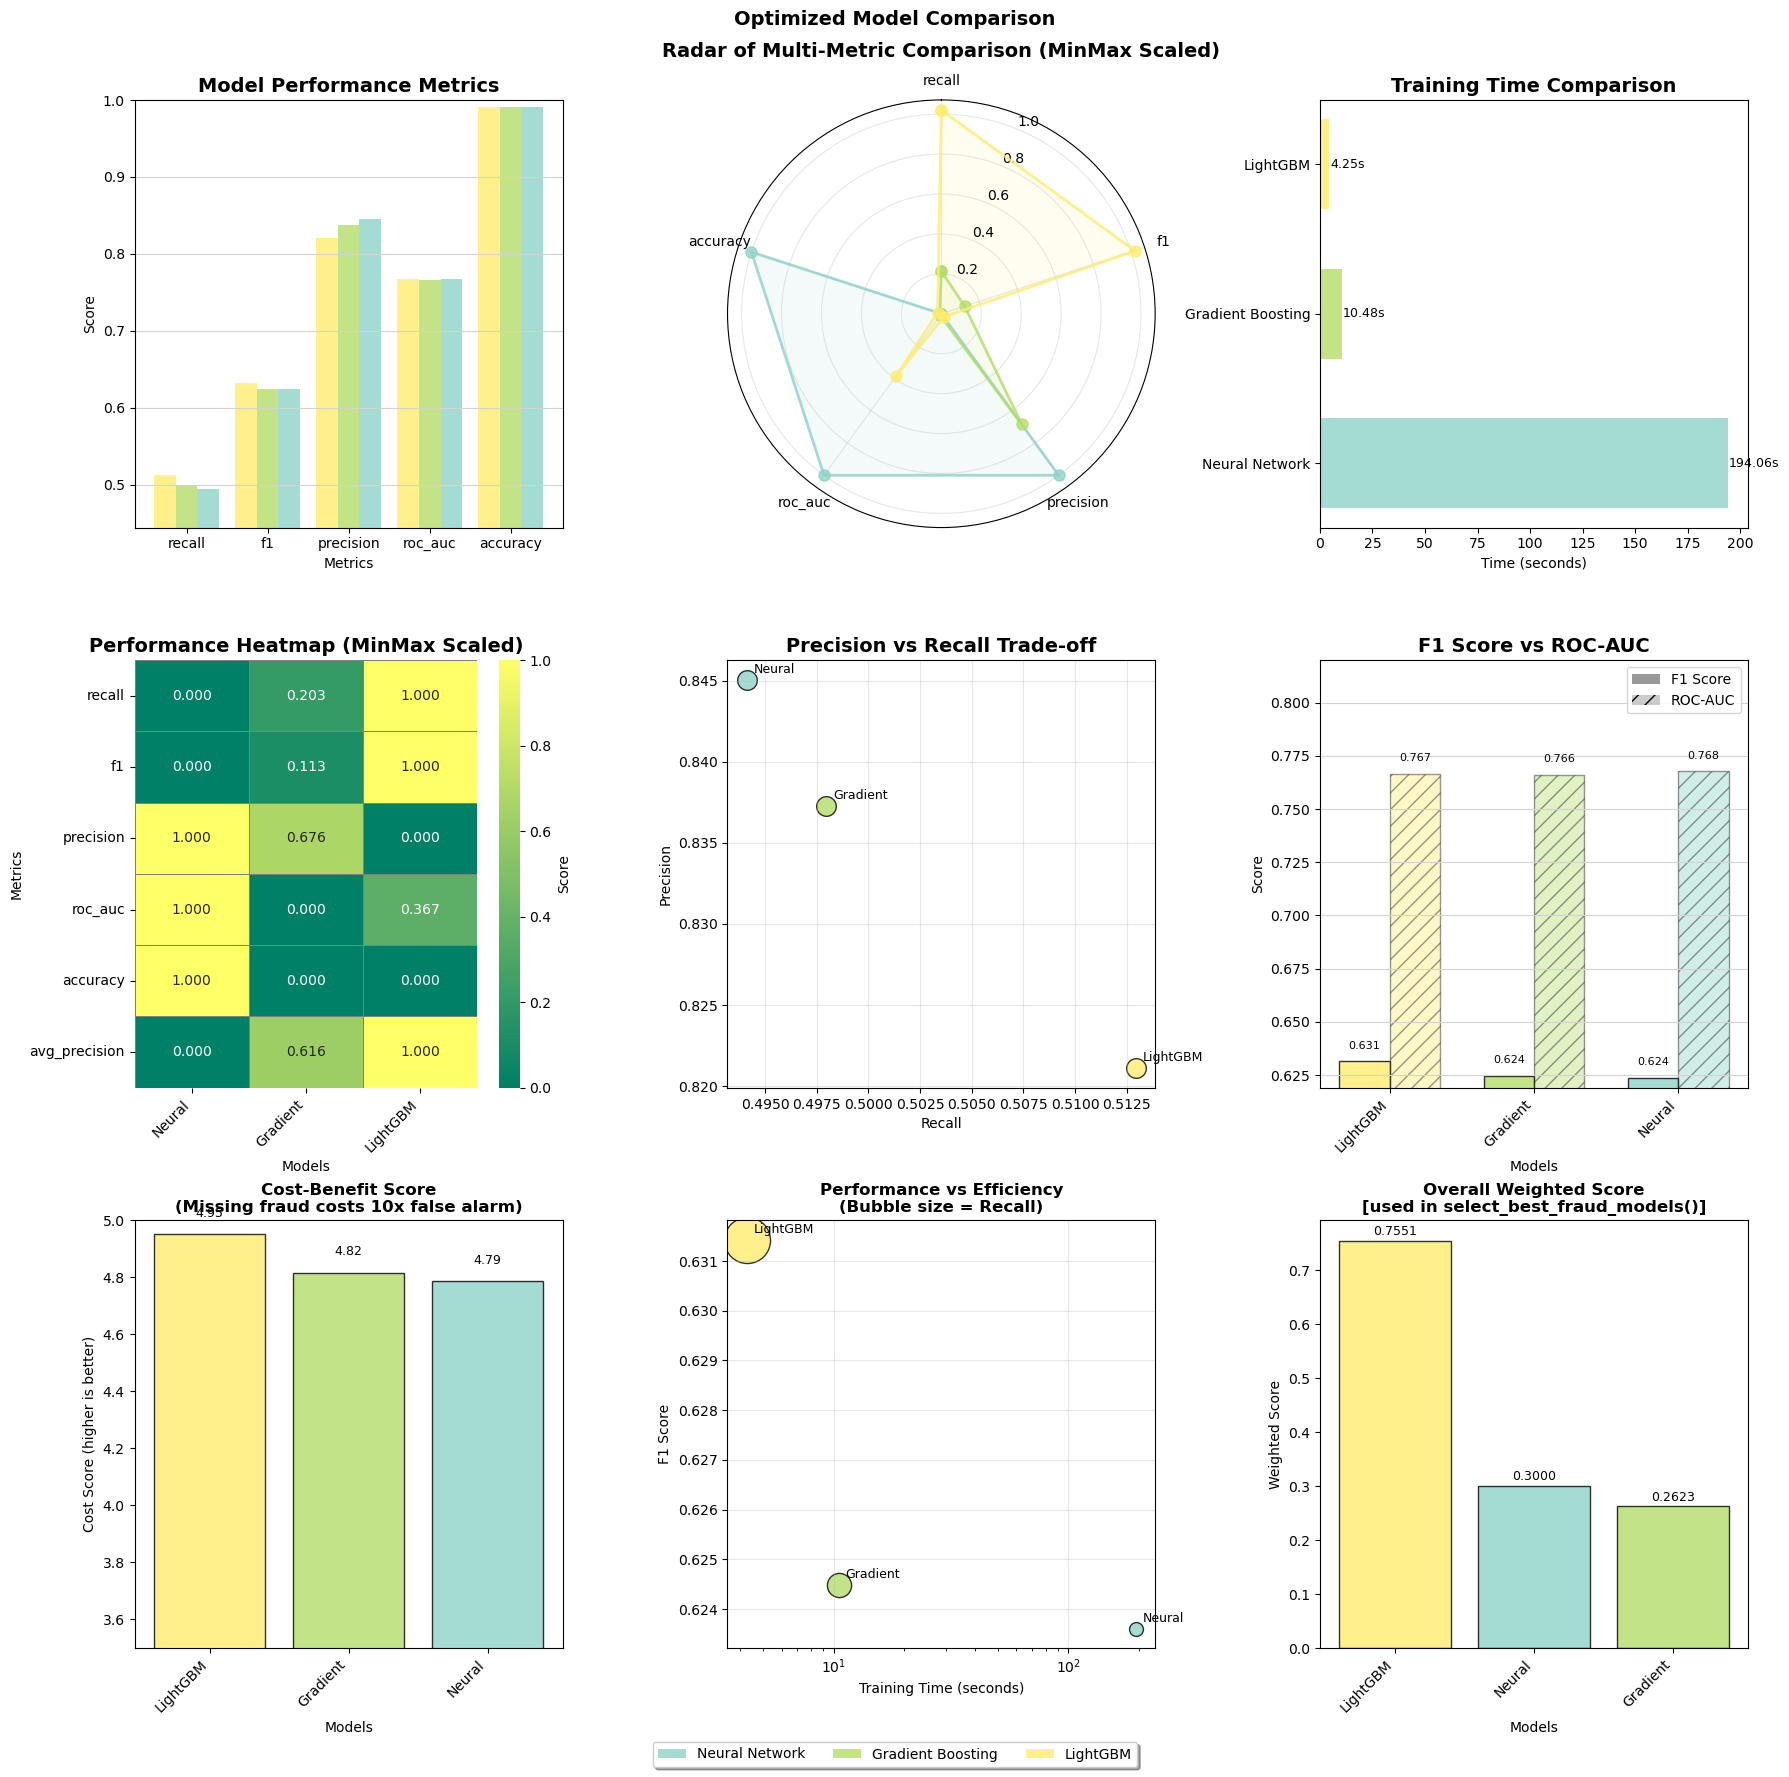

In [5]:
from func import plot_model_comparison
plot_model_comparison(optimized_df, weights = fraud_weights, top_n=1, 
                      figsize=(18, 18), figsave=True, figtitle = 'Optimized Model Comparison')